In [9]:
import os, sys
import pandas as pd
import numpy as np
import matminer as mm
import pymatgen as pym
from scipy import stats
import requests
from pprint import pprint
from copy import deepcopy
import joblib
from itertools import combinations
from PIL import Image
import itertools
import traceback
import re
from watermark import watermark

import sklearn as sk
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn import linear_model

from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition

from pymatgen.core.periodic_table import Element
from pymatgen.util.string import latexify

import shap

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cycler
prop_cycle = plt.rcParams['axes.prop_cycle']
DEFAULT_COLORS = prop_cycle.by_key()['color']
#plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# plt.rc('text', usetex=True)
FONTSIZE=9
plt.rc('font', **{'size':FONTSIZE})
DEFCOLS = prop_cycle.by_key()['color']
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
# https://tex.stackexchange.com/questions/314190/upright-sans-serif-greek-in-math-mode
# plt.rcParams['text.latex.preamble'] = [
#        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
#        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#        r'\usepackage{helvet}',    # set the normal font here
#        r'\usepackage{sansmathfonts}',  # load up the sansmath so that math -> helvet
#        #r'\sansmath',              # <- tricky! -- gotta actually tell tex to use!
# ]
plt.rcParams['text.latex.preamble'] =\
r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmathfonts}'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [3]:
print(watermark())

Last updated: 2022-11-15T16:13:52.153138-08:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.6.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



In [4]:
print(watermark(packages="numpy,scipy,sklearn,matminer,pymatgen,pandas"))

numpy   : 1.23.4
scipy   : 1.9.3
sklearn : 1.1.3
matminer: 0.8.0
pymatgen: 2022.11.7
pandas  : 1.5.1



### Versions used during development

numpy   : 1.23.4

scipy   : 1.9.3

sklearn : 1.1.3

matminer: 0.8.0

pymatgen: 2022.11.7

pandas  : 1.5.1

# 0. Helper/plotting functions

In [1]:
def recursive_pareto(data,oldmask,allinds,depth,ncalls=0):
    # data : (n_samples, n_costs)
    # oldmask : (n_samples) True once material has already been assigned to a pareto stage 
    # allinds : np.arange(data.shape[0])
    # depth : (n_samples) pareto stage after previous pareto optimal's removed
    
    ncalls += 1
    
    if np.sum(oldmask)==data.shape[0]:
        # all materials finished
        return ncalls
    
    # only consider non-previously optimal materials (oldmask == False)
    pareto = is_pareto_efficient(data[np.invert(oldmask)])
    print('%d pareto optimal materials this round'%np.sum(pareto))
    #print(pareto)
    originds = allinds[np.invert(oldmask)][pareto]
    oldmask[originds]=True
    print('%d total materials'%np.sum(oldmask))
    depth[originds]=ncalls
    
    recursive_pareto(data,oldmask,allinds,depth,ncalls)
    
def dataset_pareto(targets):
    """
    
    """
    paretoTarget=27
    paretoThermo=dH_HEA_predict 
    data = np.vstack((np.abs(np.array(dH_HEA_predict)-paretoTarget),-1*HtoM_HEA_predict,-1*Hwtpercent,matcost)).T
    pareto = is_pareto_efficient(data)
    

In [2]:
def HtoM_from_wtfrac(wtfrac,comp):
    """
    Convert H/M ratio to a wt fraction for a given Pymatgen composition object
    """
    MWs = [pym.core.Element(el).atomic_mass for el in comp.as_dict().keys()]
    stoich = [comp.get_atomic_fraction(el) for el in comp.as_dict().keys()]
    #print(stoich, np.sum(stoich))
    assert np.isclose(np.sum(stoich),1.0,rtol=1e-05)
    molefrac = wtfrac*np.sum(np.array(MWs)*np.array(stoich))/(1.008*(1-wtfrac))
    HtoM = molefrac/np.sum(stoich)
    return HtoM

def wtfrac_from_HtoM(HtoM,comp):
    els = [pym.core.Element(el) for el in comp.as_dict().keys()]
    MWs = [pym.core.Element(el).atomic_mass for el in comp.as_dict().keys()]
    stoich = [comp.get_atomic_fraction(el) for el in comp.as_dict().keys()]
    assert np.isclose(np.sum(stoich),1.0,rtol=1e-05) # normalized so there is 1 metal atom
    newcomp = pym.core.Composition("".join(['%s%.10f'%(str(el),amt) for el,amt in zip(els,stoich)]+['H%.10f'%HtoM]))
    return newcomp.get_wt_fraction('H')

def compute_raw_material_cost(el_costs,comp):
    stoich = [comp.get_atomic_fraction(el) for el in comp.as_dict().keys()]
    all_el_cost = [el_costs[el] for el in comp.as_dict().keys()]
    return np.sum(np.array(stoich)*np.array(all_el_cost))

# Faster than is_pareto_efficient_simple, but less readable.
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

def at_num_sorted(strlist):
    """
    strlist: list of chemical strings ['TiZrMnCrFeNi','HfZr']
    """
    return ["".join([str(e) for e in sorted([el for el in pym.core.Composition(c).elements if str(el) !='H'], key=lambda x: x.number)]) 
               for c in strlist]

def sk_linear_model(X,y):
    inds = np.argsort(X,axis=0).squeeze()
    fit = linear_model.LinearRegression().fit(X,y)
    pred = fit.predict(X)
    r2 = r2_score(pred,y)
    return fit, r2, pred, inds

def draw_y_equals_x(ax,c='black'):

    xlim=ax.get_xlim()
    ylim=ax.get_ylim()

    ax.plot([max(xlim[0],ylim[0]), min(xlim[1],ylim[1])],
            [max(xlim[0],ylim[0]), min(xlim[1],ylim[1])],
            linestyle='--',
            c=c,
            linewidth=1)
    
def draw_y_equals_x_v2(ax):

    xlim=ax.get_xlim()
    ylim=ax.get_ylim()

    ax.plot([min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
            [min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
            linestyle='--',
            c='black',
            linewidth=1)
    
    
def vertical_img_concat(flist,savename):
    images = [Image.open(x) for x in flist]
    widths, heights = zip(*(i.size for i in images))
    print(widths,heights)
    
    total_height = sum(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for im in images:
      new_im.paste(im, (0, y_offset))
      y_offset += im.size[1]

    if savename is not None:
        new_im.save(savename)

def horizontal_img_concat(flist,savename):
    
    images = [Image.open(x) for x in flist]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
      new_im.paste(im, (x_offset,0))
      x_offset += im.size[0]

    if savename is not None:
        new_im.save(savename)
        
    
def plot_special_marker_fcn(ax, thiscomplist, setcombinations, xvals, yvals, edgecolor="black",
            marker="*",s=100,c="red",linewidths=0.5):
    """
    To plot a specific composition as its own marker
    """

    thiscompset = set(thiscomplist)
    thiscompstr = "".join(sorted(thiscomplist, key=lambda x: Element(x).Z))
    #thiscompstr = r"$\textrm{"+thiscompstr+"}$"
    thiscompind = setcombinations.index(thiscompset)
    ax.scatter(xvals[thiscompind],yvals[thiscompind],edgecolor=edgecolor,
               marker=marker,s=s, c=c,label=thiscompstr,linewidths=linewidths)

    print("%s , x=%.2f , y=%.2f"%(thiscomplist,
                                              xvals[thiscompind],
                                              yvals[thiscompind]))
def column_to_label(colname):

    if colname == 'Heat_of_Formation_kJperMolH2':
        return r"$\Delta H$ [kJ/mol H$_2$]"
    elif colname == 'Entropy_of_Formation_JperMolH2perK':
        return r"$\Delta S$ [J/(mol H$_2$ $\cdot$ K)]"
    elif colname == 'Equilibrium_Pressure_25C':
        return r"$P_{eq}^o$"
    elif colname == 'LnEquilibrium_Pressure_25C':
        return r"$\ln (P_{eq}^o/P_o)$"
    elif colname == 'volume':
        return r"$V_{cell}$ [\AA$^3$]"
    elif colname == 'volume_ps':
        return r"$\nu_{pa}^{MP}$ [\AA$^3$/atom]"
    elif colname == 'volume_ps_generic':
        return r"$\bar{\nu_{pa}}$ [\AA$^3$/atom]"
    elif colname == 'mean_GSvolume_pa':
        return r"$\bar{\nu}_{\mathrm{pa}}^{\mathrm{Magpie}}$ [\AA$^3$/atom]"
    elif colname == 'empty_volume_ps':
        return r"$\nu_{pa}-\bar{V}_{atom}$ [\AA$^3$/atom]"
    elif colname == 'mean_CovalentRadius':
        return r"mean$\_$CovalentRadius"
    elif colname == 'mean_SpaceGroupNumber':
        return r"mean$\_$SpaceGroupNumber"
    elif colname == 'energy_per_atom':
        return r"$E_{atom}$"
    elif colname == 'formation_energy_per_atom':
        return r"$E_{f,atom}$"
    elif colname == 'mean_Electronegativity':
        return r"mean$\_$Electronegativity"
    elif colname == 'most_Electronegativity':
        return r"most$\_$Electronegativity"
    elif colname == 'mean_MeltingT':
        return r"mean$\_$MeltingT"
    elif colname == 'normalized_delH':
        return r"$\Delta H / (RT^o)$"
    elif colname == 'normalized_delS':
        return r"$\Delta S / R$"
    elif colname == 'Hydrogen_Weight_Percent':
        return r"$\mathrm{H }wt.\%$"
    elif colname == 'HtoM':
        return r"$\mathrm{H/M}$"
    elif colname == 'Ef_eV':
        return r"$\textrm{E}_{F}\textrm{ [eV]}$"
    else :
        print("Add translation for %s"%colname)
        return colname


def cweighted_elementalH_formE(comp, elem_table):
    """
    comp : pymatgen.core.composition.Composition
    
    elem_table : DataFrame
        - contains one column with 'Species' element string and 'Ef' property column  
    """
    c = comp.as_dict()
    atlist = c.keys()-'H'
    tot = sum([c[key] for key in atlist])
    frac = [c[key]/tot for key in atlist]
    #print(atlist, tot, frac)
    formElist = [float(elem_table.loc[elem_table['Species']==key]['Ef'])\
                 for key in atlist]
    formEcweighted = np.array(formElist)*frac
#     print(c, tot, frac)
#     print(formEcweighted)
#     print(formElist, np.sum(formEcweighted), np.std(formEcweighted))

    return [min(formElist), max(formElist), 
            np.sum(formEcweighted), np.std(formEcweighted)]

def filter_by_predict_value(limlower, limupper, y, holdlower=True, holdupper=True):
    """
    Filters out data in y above and below critical values and optionally
    stores them as holdout data
    """

    if limlower is not None and limupper is None:
        holdout_indices = np.where(y<limlower)
        keep_indices    = np.where(y>limlower)
    elif limlower is None and limupper is not None:
        holdout_indices = np.where(y>limupper)
        keep_indices    = np.where(y<limupper)
    elif limlower is not None and limupper is not None:
        if holdlower and holdupper:
            holdout_indices = np.where((y<limlower) | (y>limupper))[0]
        elif holdlower and not holdupper:
            holdout_indices = np.where(y<limlower)
        elif not holdlower and holdupper:
            holdout_indices = np.where(y>limupper)
        else:
            holdout_indices = np.array([],dtype=int)

        keep_indices    = np.where((y>limlower) & (y<limupper))[0]
    else:
        keep_indices = slice(0,len(y))
        holdout_indices = np.array([],dtype=int)

    return keep_indices, holdout_indices

def compute_mean_relative_error(y_true, y_pred):
    return np.average(np.abs((y_pred-y_true)/y_true)*100)

def magpie_featurize_data(df,comp_col='Composition_Formula',
                             keep_comp_col = False,
                             keep_cols=[],
                             elem_prop=None):
    
    print("Shape of df to featurize: ", df.shape)
    origcols = set(df.columns)
        
    conversion_featurizer = StrToComposition(target_col_id='composition_obj')
    conversion_featurizer.set_chunksize(5000)
    df = conversion_featurizer.featurize_dataframe(df, comp_col)

    feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                              cf.ElementProperty.from_preset("magpie"),
                                              cf.ValenceOrbital(props=['avg']), 
                                              cf.IonProperty(fast=True)])

    feature_calculators.set_chunksize(1000)
    # plshalp
    feature_labels = feature_calculators.feature_labels()
    df = feature_calculators.featurize_dataframe(df,col_id='composition_obj')
    
    
    #df.columns = [col.replace('_','\_') for col in df.columns]
    df.columns = [col.replace('MagpieData','') for col in df.columns]
    df.columns = [col.replace('average','mu') for col in df.columns]
    df.columns = [col.replace('maximum','max') for col in df.columns]
    df.columns = [col.replace('minimum','min') for col in df.columns]
    
    if keep_comp_col:
        origcols.remove(comp_col)
    
    for elem in keep_cols:
        try:
            origcols.remove(elem)
        except:
            pass
    
    features = df.drop(list(origcols)+['composition_obj'],
                       axis=1,inplace=False)
        
    if elem_prop is not None:
        elemH_formE = [cweighted_elementalH_formE(c,elem_prop)\
                   for c in df['composition_obj']]
        elemH_formE_df = pd.DataFrame(elemH_formE,columns=['E_HM min',
                                                           'E_HM max',
                                                           'E_HM mu',
                                                           'E_HM dev'])
        aug_features = pd.concat((features,elemH_formE_df),axis=1,sort=False)
        #print(aug_features.columns)
    else:
        aug_features = deepcopy(features)
        
    print("Shape of returned features: ", aug_features.shape)
    return aug_features

def prettify_magpie_v3(s):
            
    if 'E_HM mu' in s:
        s = r"$\Delta \bar{H}_{b}$"
    elif ' mean GSvolume_pa' in s:
        s = r"$\bar{\nu}_{pa}$"
    elif ' mode GSvolume_pa' in s:
        s = r"$\mathring{\nu}_{pa}$"
    elif ' mean MendeleevNumber' in s:
        s = r"$\bar{Me\#}$"
    elif ' mean NdUnfilled' in s:
        s = r"$\bar{N}_{d,u}$"
    elif ' avg_dev NdUnfilled' in s:
        s = r"$\hat{N}_{d,u}$"
    elif ' mean SpaceGroupNumber' in s:
        s = r"$\bar{\textrm{SG}}\#$"
    elif ' mean Electronegativity' in s:
        s = r"$\bar{\chi}$"
    elif ' avg_dev Electronegativity' in s:
        s = r"$\hat{\chi}$"
    elif ' mean Column' in s:
        s = r"$\bar{C}$"
    elif ' avg_dev Column' in s:
        s = r"$\hat{C}$"
    elif ' mean CovalentRadius' in s:
        s = r"$\bar{r}_c$"
    elif ' mean NValence' in s:
        s = r"$\bar{N}_v$"
    elif ' mean MeltingT' in s:
        s = r"$\bar{T}_m$"
    elif ' avg_dev NdValence' in s:
        s = r"$\hat{N}_{v,d}$"
    elif ' mean Number' in s:
        s = r"$\bar{N}$"
    elif ' avg_dev GSmagmom' in s:
        s = r"$\hat{\mu}$"
    else:
        s = s.replace('_','\_')
        #s = r"$\textrm{" + s + "}$"
    #final = r'%s'%s
    return s

In [3]:
def get_shap_values(model, features, top=9):
    if hasattr(model,'_finalest'):
        m = model._finalest
    else:
        m = model
    fea = deepcopy(features)
    fea.columns = [prettify_magpie_v3(col) for col in fea.columns]
    explainer = shap.TreeExplainer(m)
    shap_values = explainer.shap_values(fea)
    shap_obj = explainer(fea)
    return shap_values

def summarize_shap_values(shap_values, features, savename='tmp',figsize=None, top=9):
    
    print(type(features))
    fea = deepcopy(features)

    try:
        #plt.rcParams['figure.constrained_layout.use'] = True
        print(fea.columns)
        fea.columns = [prettify_magpie_v3(col) for col in fea.columns]
        # formula for default plot size = (1.5 * max_display + 1, 0.8 * max_display + 1)
        if figsize is not None:
            shap.summary_plot(shap_values, fea, max_display=top, show=False, plot_size=figsize)
        else:
            shap.summary_plot(shap_values, fea, max_display=top, show=False)
        #shap.plots.beeswarm(shap_obj, max_display=top, plot_size=(3.0,2.2))
        
        for ax in plt.gcf().get_axes():
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                         ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(FONTSIZE)

        plt.gcf().axes[-1].set_aspect(25)
        plt.gcf().axes[-1].set_box_aspect(25)
        #print(shap_values)
        
    except Exception:
        fea = deepcopy(features)
        traceback.print_exc()
    


In [4]:
def plot_summary(GBTobj, fea, titles=None, savename=None, prettify_Magpie=False, limlower=None, limupper=None):

    ######################################################################
    # Plot publication figure of combined k-fold train and test
    ######################################################################

    HEIGHT = 1.7
    DPI = 600
    
    # so we can recalculate MAE over target range
    all_y_train_true = []
    all_y_train_pred = []
    all_y_test_true = []
    all_y_test_pred = []

    # loop over all kfolds
    numKfolds = len(GBTobj._all_test_pred)
    alltestMAEs = []
    for i in range(numKfolds):
        
        # Filter values if in the range over which we actually care about 
        # the error metric
        y_train_true = GBTobj._all_train_pred[i][0]
        y_train_pred = GBTobj._all_train_pred[i][1]
        keep_indices, _ = filter_by_predict_value(limlower,limupper,y_train_true)
        y_train_true = y_train_true[keep_indices]
        y_train_pred = y_train_pred[keep_indices]
        
        y_test_true = GBTobj._all_test_pred[i][0]
        y_test_pred = GBTobj._all_test_pred[i][1]
        keep_indices, _ = filter_by_predict_value(limlower,limupper,y_test_true)
        y_test_true = y_test_true[keep_indices]
        y_test_pred = y_test_pred[keep_indices]
        
        all_y_train_true += list(y_train_true)
        all_y_train_pred += list(y_train_pred)
        
        all_y_test_true += list(y_test_true)
        all_y_test_pred += list(y_test_pred)
        
        testMAE = np.average(np.abs(np.array(all_y_test_true)-np.array(all_y_test_pred)))
        alltestMAEs.append(testMAE)

        trainMAE = np.average(np.abs(np.array(all_y_train_true)-np.array(all_y_train_pred))) 

    
    ######################################################################
    #K-fold concatenated train and test sets
    ######################################################################

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(4.5,HEIGHT), sharey=True,constrained_layout=True)

    trainlabel = r"$\langle$MAE$\rangle_{\mathrm{Train}}$ = %.2f"%(trainMAE)#np.average(GBTobj._all_train_mae))
    testlabel = r"$\langle$MAE$\rangle_{\mathrm{Test}}$ = %.2f"%(testMAE)#np.average(GBTobj._all_test_mae))

    ax[0].scatter(all_y_train_true,all_y_train_pred, edgecolor='blue',
                                                        color='blue',
                                                        linewidths=1,
                                                        alpha=0.1,
                                                        label=trainlabel)
    ax[1].scatter(all_y_test_true,all_y_test_pred, edgecolor='blue',
                                                        color='blue',
                                                        linewidths=1,
                                                        alpha=0.1,
                                                        label=testlabel)        
        
    draw_y_equals_x(ax[0])
    draw_y_equals_x(ax[1])
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    ax[0].set_ylabel(r"Model %s"%column_to_label(GBTobj._predict_column))
    ax[0].set_xlabel(r"True %s"%column_to_label(GBTobj._predict_column))
    ax[1].set_xlabel(r"True %s"%column_to_label(GBTobj._predict_column))
    
    if titles is not None:
        plt.title(titles[0])
    plt.savefig('/var/tmp/figTrainTest.png',dpi=DPI)
    plt.savefig('/var/tmp/figTrainTest.pdf')
    plt.show()
    plt.close()
    
    ######################################################################
    #K-fold concatenated test sets
    ######################################################################
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(2.1,HEIGHT), sharey=True,constrained_layout=True)

    testlabel = r"$\langle \mathrm{MAE} \rangle_K$ = %.2f"%(testMAE)#np.average(GBTobj._all_test_mae))

    cm = plt.cm.get_cmap('inferno')
    sc = ax.hexbin(all_y_test_true,all_y_test_pred,
                   cmap=cm,mincnt=1,gridsize=20,label=testlabel,bins='log')#,vmin=min(allweights), vmax=max(allweights),linewidths=1,alpha=0.5,c=allweights)


    cb = plt.colorbar(sc)
    #cb.ax.set_title(r"$\sum f_i \textrm{MW}_i$")
    cb.ax.set_title(r"\#ex")   
        
    draw_y_equals_x(ax,c='cyan')
    
    print(np.average(alltestMAEs), np.std(alltestMAEs))
    
    ax.set_ylabel(r"Model %s"%column_to_label(GBTobj._predict_column))
    ax.set_xlabel(r"True %s"%column_to_label(GBTobj._predict_column))
    
    if titles is not None:
        plt.title(titles[1])
    plt.savefig('/var/tmp/figTest.pdf')
    plt.savefig('/var/tmp/figTest.png',dpi=DPI)
    plt.show()
    plt.close()
    
    
    ######################################################################
    # SHAP analysis
    ######################################################################
    # dH models
    #plt.rcParams['figure.constrained_layout.use'] = True
    shapvals = get_shap_values(GBTobj, fea)
    summarize_shap_values(shapvals, fea, figsize=(2.8,HEIGHT),top=5)
    plt.xlabel('SHAP value')
    if titles is not None:
        plt.title(titles[2])
    plt.tight_layout(pad=0.35)
    plt.savefig('/var/tmp/figSHAP.pdf')
    plt.savefig('/var/tmp/figSHAP.png',dpi=DPI)
    plt.show()
    plt.close()
    #plt.rcParams['figure.constrained_layout.use'] = False

    ######################################################################
    # Plot publication figure of average importances over all k-fold models
    ######################################################################
#     fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(2.9,2),constrained_layout=True)

#     all_feature_importance = np.sum(GBTobj._all_feature_importance, axis=0)
#     all_feature_importance/=(GBTobj._nsplits)
#     sorted_idx = np.argsort(all_feature_importance)
#     pos = np.arange(sorted_idx.shape[0]) + .5
#     maxdisplay = min(len(pos),8) # we only want to plot a max num of features

#     ax.barh(pos[-maxdisplay:], all_feature_importance[sorted_idx][-maxdisplay:],
#             align='center')
#     ax.set_yticks(pos[-maxdisplay:])
#     if type(GBTobj._allX) == np.ndarray:
#         pass
#     else:
#         if prettify_Magpie:
#             ticklabels = [prettify_magpie_v3(feature)\
#                           for feature in GBTobj._allX.columns[sorted_idx][-maxdisplay:]]
#         else:
#             ticklabels = [feature.replace('_','\_')\
#                           for feature in GBTobj._allX.columns[sorted_idx][-maxdisplay:]]
#         ax.set_yticklabels(ticklabels)
#     ax.set_xlabel(r'$\langle$Relative Importance$\rangle$')
#     ax.set_xlim((0,100))

#     if titles is not None:
#         plt.title(titles[3])
#     plt.savefig('/var/tmp/figFeature.png',dpi=DPI)


    ######################################################################
    # Plot the MAE of subsets of the data binned on the true predict value
    ######################################################################
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(2.1,HEIGHT), constrained_layout=True)

    nbins=15
    concatenated = np.concatenate(GBTobj._all_test_pred,axis=1)
    if limlower != None and limupper != None:
        concatenated = concatenated[:,np.where(np.logical_and(concatenated[0,:]>=limlower, concatenated[0,:]<=limupper))[0]]
    hist, bin_edges = np.histogram(concatenated, bins=nbins)
    binned_AEs = [[] for _ in range(len(hist))]
    for i in range(len(concatenated[0,:])):
        bin_ind=1

        while concatenated[0,i] > bin_edges[bin_ind]:
            bin_ind+=1

        #print(concatenated[0,i], bin_ind)
        binned_AEs[bin_ind-1].append(np.abs(concatenated[0,i]-concatenated[1,i]))


    allxs = np.array([bin_edges[i-1]+(bin_edges[i]-bin_edges[i-1])/2\
                      for i in range(1,len(bin_edges))])
    allys = np.array([np.mean(data) for data in binned_AEs])

    allxs = allxs[~np.isnan(allys)]
    allys = allys[~np.isnan(allys)]

    ax.hist(concatenated[0,:],color='blue',bins=nbins)
    ax.set_xlabel(r"True %s"%column_to_label(GBTobj._predict_column))
    ax.set_ylabel(r"HydPARK Frequency")
    ax.tick_params(axis='y', colors='blue')
    ax.yaxis.label.set_color('blue')

    axtwin = ax.twinx()
    axtwin.plot(allxs, allys,c="orange",marker="s",markerfacecolor="white")
    axtwin.set_ylabel(r"$\langle$MAE$\rangle_{\mathrm{Test}}$ within bin")
    axtwin.tick_params(axis='y', colors='orange')
    axtwin.yaxis.label.set_color('orange')

    twin_ylims = axtwin.get_ylim()
    axtwin.set_ylim((0,min(twin_ylims[1],15)))
    
    if titles is not None:
        plt.title(titles[3])
    plt.savefig('/var/tmp/figMAEdist.pdf')
    plt.savefig('/var/tmp/figMAEdist.png',dpi=DPI)
    
    sep = np.ones(int(DPI*HEIGHT)*10, dtype=np.uint8)
    sep = np.reshape(sep,(int(DPI*HEIGHT),1*10))
    im = Image.fromarray(sep)
    im.save("/var/tmp/sep.png")


    # too annoying to get the subplot sizing correct in matplotlib, 
    # so just save the images and recombine with
    flist = ['/var/tmp/figTest.png', '/var/tmp/sep.png', '/var/tmp/figSHAP.png', '/var/tmp/sep.png', '/var/tmp/figMAEdist.png']
    horizontal_img_concat(flist,savename)

    plt.show()

In [5]:
class GBTRegressorPersistent():
    
    def __init__(self, allX, ally, predict_column, param,
                                      test_size = 0.1,
                                      toplot=True,
                                      limlower=0,
                                      limupper=100,
                                      seed=0,
                                      keepfeatures=None,
                                      holdlower=True,
                                      holdupper=True,
                                      additional_holdout={}):
        self._allX = allX
        self._ally = ally
        self._predict_column = predict_column
        self._param = param
        self._test_size = test_size
        self._toplot = toplot
        self._limlower = limlower
        self._limupper = limupper
        self._seed = seed
        self._keepfeatures = keepfeatures
        self._holdlower = holdlower
        self._holdupper = holdupper
        self._additional_holdout=additional_holdout
        
        self.run()
                
    def run(self,retrain=True):
        keep_indices, holdout_indices =\
            filter_by_predict_value(self._limlower,self._limupper,
                                    self._ally,self._holdlower,self._holdupper)

        # set up training data
        self._X = np.array(self._allX)[keep_indices]
        self._y = np.array(self._ally)[keep_indices]

        # setup kept out data if outside limits
        self._Xhold = np.array(self._allX)[holdout_indices]
        self._yhold = np.array(self._ally)[holdout_indices]

        # test/train split setup 
        self._nsplits=int(np.ceil(1/self._test_size))
        self._kf = KFold(n_splits=self._nsplits, shuffle=True, random_state=self._seed)
        self._kf.get_n_splits(self._X)
        self._modelstats = []

        # store results of each kfold
        self._all_train_pred = []
        self._all_train_mae = []
        self._all_test_pred = []
        self._all_test_mae = []
        self._all_hold_pred = []
        self._all_hold_mae = []
        self._all_feature_importance=np.zeros((self._nsplits,np.shape(self._X)[1]))


        if retrain:
            self._all_est = []
        
        print('X shape: ', np.shape(self._X))
        print('y shape: ', np.shape(self._y))
        print("K-fold | Train MAE | Test MAE | Max(y) | Min(y)")
        for it, (train_index,test_index) in enumerate(self._kf.split(self._X)):

            X_train, X_test = self._X[train_index], self._X[test_index]
            y_train, y_test = self._y[train_index], self._y[test_index]

            if retrain:
                est = GradientBoostingRegressor(**self._param).fit(X_train, y_train)
                self._all_est.append(est)
            else:
                est = self._all_est[it]

            # evaluate model on the training set
            y_train_pred = est.predict(X_train)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            self._all_train_pred.append((y_train, y_train_pred))
            self._all_train_mae.append(train_mae)

            # evaluate model on the test set
            y_test_pred = est.predict(X_test)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            self._all_test_pred.append((y_test,y_test_pred))
            self._all_test_mae.append(test_mae)

            # evaluate model on the holdout set
            if len(self._yhold) != 0:
                yhold_pred = est.predict(self._Xhold)
                holdout_mae = mean_absolute_error(self._yhold, yhold_pred)
                self._all_hold_pred.append((self._yhold, yhold_pred))
                self._all_hold_mae.append(holdout_mae)

            # evaluate model on any additional holdout sets
            for key in self._additional_holdout.keys():
                thisy = self._additional_holdout[key]['yhold']
                thisy_pred = est.predict(self._additional_holdout[key]['Xhold'])
                this_mae = mean_absolute_error(thisy, thisy_pred)
                print(this_mae)
                self._additional_holdout[key]['allhold_pred'].append((thisy, thisy_pred))
                self._additional_holdout[key]['allhold_mae'].append(this_mae)

            print("%d\t%.2f\t%.2f\t%.2f\t%.2f"%(it, train_mae, test_mae, np.max(y_test), np.min(y_test)))
            self._modelstats.append([self._seed, train_mae, test_mae])
            
            # Feature importance
            feature_importance = est.feature_importances_
            # normalize relative to max importance
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            self._all_feature_importance[it,:]=feature_importance
            
        self._finalest = GradientBoostingRegressor(**self._param).fit(self._X, self._y)
        
        if self._toplot:
            self.plot_training()
        
    def plot_training(self):

        ncols=4
        fig, ax = plt.subplots(nrows=self._nsplits,ncols=ncols,
                               figsize=(3.3*ncols,1.9*self._nsplits),
                               gridspec_kw={'width_ratios': [3,3,3,1]},
                               constrained_layout=True)
        
        for it, (train_index,test_index) in enumerate(self._kf.split(self._X)):

            X_train, X_test = self._X[train_index], self._X[test_index]
            y_train, y_test = self._y[train_index], self._y[test_index]
            
            ######################################################################
            # Train/test parity plot for each k-fold
            ######################################################################
            # Training parity plot
            ax[it,0].scatter(self._all_train_pred[it][0],self._all_train_pred[it][1],
                             edgecolor='blue', linewidths=1, alpha=0.3,
                             label="Train MAE = %.2f"%(self._all_train_mae[it]))
            ax[it,0].set_xlabel(r"True %s"%column_to_label(self._predict_column))
            ax[it,0].set_ylabel(r"Model %s"%column_to_label(self._predict_column))
            draw_y_equals_x(ax[it,0])
            ax[it,0].legend(loc='best')

            # Test parity plot
            SC = stats.spearmanr(self._all_test_pred[it][0],self._all_test_pred[it][1])
            ax[it,1].scatter(self._all_test_pred[it][0],self._all_test_pred[it][1],
                             edgecolor='blue', linewidths=1, alpha=0.3,
                             label="Val MAE (SC)= %.2f (%.2f)"%(self._all_test_mae[it],SC[0]))

            # Plot holdout with special color
            if len(self._yhold) != 0:
                ax[it,1].scatter(self._all_hold_pred[it][0],self._all_hold_pred[it][1],
                                 edgecolor='red', linewidths=1, alpha=0.3,
                                 labeall="Holdout MAE = %.2f"%(self._all_holdout_mae[it]))
            ax[it,1].set_xlabel(r"True %s"%column_to_label(self._predict_column))
            ax[it,1].set_ylabel(r"Model %s"%column_to_label(self._predict_column))
            draw_y_equals_x(ax[it,1])
            ax[it,1].legend(loc='best')


            # Learning curve plot
            test_score = np.zeros((self._param['n_estimators'],), dtype=np.float64)
            for i, y_pred in enumerate(self._all_est[it].staged_predict(X_test)):
                test_score[i] = self._all_est[it].loss_(self._all_test_pred[it][0], y_pred)

            # Plot staged predicitions
            ax[it,2].plot(np.arange(self._param['n_estimators']) + 1, 
                          self._all_est[it].train_score_, 'b-', label='Training Set Deviance')
            ax[it,2].plot(np.arange(self._param['n_estimators']) + 1, 
                          test_score, 'r-', label='Val Set Deviance')
            ax[it,2].legend(loc='upper right')
            ax[it,2].set_xlabel('Boosting Iterations')
            ax[it,2].set_ylabel('Deviance')


            # Feature importance plot
            feature_importance = self._all_feature_importance[it]
            sorted_idx = np.argsort(feature_importance)
            pos = np.arange(sorted_idx.shape[0]) + .5
            maxdisplay = min(len(pos),8) # we only want to plot a max num of features

            ax[it,3].barh(pos[-maxdisplay:], feature_importance[sorted_idx][-maxdisplay:], align='center')
            ax[it,3].set_yticks(pos[-maxdisplay:])
            if type(self._allX) == np.ndarray:
                pass
            else:
                ticklabels = [feature.replace('_','\_')\
                              for feature in self._allX.columns[sorted_idx][-maxdisplay:]]
                ax[it,3].set_yticklabels(ticklabels)
            ax[it,3].set_xlabel('Relative Importance')
            ax[it,3].set_xlim((0,100))

        plt.show()
        plt.close()

In [6]:
def load_all_models(version):
    """
    Loads all cached models in this repository
    """

    try:
        estplus_dH = joblib.load(os.path.join('models',version,
                                              'model_Heat_of_Formation_kJperMolH2.joblib'))
    except:
        estplus_dH = None
    
    # estplus_NormDHB = joblib.load(os.path.join('models',modelVersion,'fea',
    #                                            'model_NormDHB.joblib'))
    
    try:
        estplus_HtoM = joblib.load(os.path.join('models',version,
                                                'model_HtoM.joblib'))
    except:
        estplus_HtoM = None
    
    try:
        estplus_lnPeqo = joblib.load(os.path.join('models',version,
                                                  'model_LnEquilibrium_Pressure_25C.joblib'))
    except:
        estplus_lnPeqo = None
    
    try:
        estplus_dS = joblib.load(os.path.join('models',version,
                                              'model_Entropy_of_Formation_JperMolH2perK.joblib'))
    except:
        estplus_dS = None
    
    return estplus_dH, estplus_HtoM, estplus_lnPeqo, estplus_dS


In [10]:
HtoM_from_wtfrac(0.028,pym.core.Composition('Ti23.333V23.333Nb23.3333Cr30'))

1.7241759258141283

In [11]:
HtoM_from_wtfrac(0.021,pym.core.Composition('TiZrCrMnFeNi'))

1.278811801299512

# 1. Pre-tabulated some data

In [12]:
##########################################################################
# Get All H2 storage materials in MP
##########################################################################
#https://www.materialsproject.org/#search/materials/{%22nelements%22%3A{%22%24gt%22%3A1}%2C%22notelements%22%3A[%22C%22%2C%22N%22%2C%22O%22%2C%22F%22%2C%22Cl%22%2C%22S%22%2C%22P%22]%2C%22elements%22%3A%22H%22}

In [13]:
##########################################################################
# Get M-H form. energy/atom from Sanliang's OQMD table
##########################################################################
elem_Ef_OQMD = pd.read_csv('ml_data/ElementalH_Ef_OQMD.csv')
ellist=elem_Ef_OQMD['Species']

In [14]:
##########################################################################
# Get MP MH formation energies
##########################################################################
#MAPIKEY = open("MY_MP_API.txt","r").readlines()[0].strip()
MAPIKEY = os.environ['MY_MP_API']
if not os.path.exists('ml_data/MP_MH.txt'):
    elem_Ef_MP = pd.DataFrame()
    numbers_MP = []
    formulas_MP = []
    Ef_MP = []
    for species in ellist:
        if type(species) == str:
            # missing values stored as <class 'float'> nan
            print(type(species),species)
            r = requests.get("https://www.materialsproject.org/rest/v2/materials/"+\
                             "H-%s/vasp?API_KEY=%s"%(species,MAPIKEY))
            formulas = [dat['pretty_formula'] for dat in r.json()['response']]
            allEfperAtom = [dat['formation_energy_per_atom'] for dat in r.json()['response']]
            if len(allEfperAtom) !=0:
                formulas_MP+=formulas
                Ef_MP+=allEfperAtom
            else:
                pass
        else:
            pass
    elem_Ef_MP['Composition_Formula']=formulas_MP
    elem_Ef_MP['Ef']=Ef_MP
    elem_Ef_MP.to_csv('ml_data/MP_MH.txt', sep=' ', index=False)
else:
    elem_Ef_MP = pd.read_csv('ml_data/MP_MH.txt',index_col=False)

In [15]:
##########################################################################
# Get elemental MH formation enthalpy per H2, at most stable H density
##########################################################################

def get_enthalpy_per_H2(df):
    """
    df contains 'Composition_Formula' and 'Ef' (formation enthalpy)
    returns: 'Heat_of_Formation_kJperMolH2'
    """

    df['composition_obj'] = [pym.core.Composition(c) for c in df['Composition_Formula']]

    df['numEls'] = [len(c.as_dict().keys()) for c in df['composition_obj']]

    df = df[df['numEls']==2]

    df['numHs'] = [c.as_dict()['H'] for c in df['composition_obj']]

    df['Mtype'] = [(set(c.as_dict().keys())-set('H')).pop() for c in df['composition_obj']]

    df['numMs'] = [c.as_dict()[M] for c,M in zip(df['composition_obj'],df['Mtype'])]
    
    # otherwise you get things like Mg149H as the most stable per H2
    df = df[df['numHs']>0.1*df['numMs']]

    df['Heat_of_Formation_kJperMolH2'] = [96.4853*Ef*(numHs+numMs)/numHs*2 for Ef,numHs,numMs in zip(df['Ef'],df['numHs'],df['numMs'])]
    
    df = df.loc[df.groupby('Mtype')['Heat_of_Formation_kJperMolH2'].idxmin(),:].sort_values('Heat_of_Formation_kJperMolH2')

    df=df[['Mtype','Heat_of_Formation_kJperMolH2']].rename(columns={'Mtype':'Composition_Formula'})

    # Sanity check:
    #https://www.osti.gov/etdeweb/servlets/purl/20553542

    # Sign convention is actually for desorption enthalpy
    df['Heat_of_Formation_kJperMolH2']*=-1
    
    return df


In [16]:
# Elemental hydrides from MP
elem_dHb_MP = pd.read_csv('ml_data/MP_MH.txt',index_col=False,delimiter=' ')
elem_dHb_MP = get_enthalpy_per_H2(elem_dHb_MP)

# Elemental hydride data from OQMD
elem_dHb_OQMD = pd.read_csv('ml_data/OQMD_MH.txt',index_col=False,delimiter=' ')
elem_dHb_OQMD = get_enthalpy_per_H2(elem_dHb_OQMD)

# Elemental hydride data by combining the two 
# OPTION1: take "priority" data source, with "nonpriority" filling any blanks
priority=elem_dHb_MP
nonpriority=elem_dHb_OQMD
elem_dHb_Combined = pd.concat([priority, 
                               nonpriority[~nonpriority.Composition_Formula.isin(\
                                              priority.Composition_Formula)]])
# OPTION2: Keep entry with max dH desorption entry
# elem_dHb_Combined = pd.concat([elem_dHb_MP,elem_dHb_OQMD],axis=0)
# elem_dHb_Combined = elem_dHb_Combined.reset_index()
# elem_dHb_Combined = elem_dHb_Combined.loc[elem_dHb_Combined.groupby('Composition_Formula')['Heat_of_Formation_kJperMolH2'].idxmax(),:]

# rename the columns if desired to be used as features:
elem_dHb_Combined_fea=elem_dHb_Combined.rename(columns={'Composition_Formula':'Species',
                                                        'Heat_of_Formation_kJperMolH2':'Ef'})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
df_raw_mat = pd.read_csv('ml_data/price_tablev2.csv')
df_raw_mat.dropna(subset=['Z'], inplace=True)
df_raw_mat['USD/kg']=[re.split(r'[^\d.]+',orig) for orig in df_raw_mat['USD/kg']]
finalcost = []
for entry in df_raw_mat['USD/kg']:
    try:
        if len(entry)>1:
            finalcost.append(np.mean(np.array(entry,dtype=float)))
        else:
            finalcost.append(float(entry[0]))
    except:
        finalcost.append(np.nan)
#df_raw_mat['USD/kg'] = [np.mean(np.array(val,dtype=float)) if len(val)>1 else val[0] for val in df_raw_mat['USD/kg']]
df_raw_mat['USD/kg'] = finalcost
convert_dict = {'Z': int, 'USD/kg': float}
df_raw_mat = df_raw_mat.astype(convert_dict)
df_raw_mat = dict(list(zip(df_raw_mat['Symbol'],df_raw_mat['USD/kg'])))
#print(df_raw_mat)

# 2. Prepare data and features

In [18]:
##########################################################################
# Provide the version for reproducing with a specific training dataset and featurizer
##########################################################################
modelVersion = 'v0.0.4'

In [19]:
##########################################################################
# Get Raw data
##########################################################################
source = 'HydPARK'
#source = 'OQMD-MH'

# Load ML-ready HYDPARK
if source == 'HydPARK':
    file = 'ml_data/HYDPARK_ML_ready.csv' 
    targetcols=['Material_Class','Composition_Formula',
                'Hydrogen_Weight_Percent','Heat_of_Formation_kJperMolH2',
                'Temperature_oC','Pressure_Atmospheres_Absolute',
                'Original_Composition_Formula',
                'Entropy_of_Formation_JperMolH2perK',
                'Equilibrium_Pressure_25C','LnEquilibrium_Pressure_25C']
    delimit_whitespace=False
# Load OQMD-MH dataset (for DFT fomration energies rather than experimental hydride reaction thermo)
elif source == 'OQMD-MH':
    file = 'OQMD_MH.txt'
    targetcols=['Composition_Formula','Ef']
    delimit_whitespace=True
else:
    raise ValueError("Non-existent data source")

# Create base training dataframe
df_train = pd.read_csv(file,usecols=targetcols,delim_whitespace=delimit_whitespace)
df_train['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                    for wt,comp in zip(df_train['Hydrogen_Weight_Percent']/100,
                                       df_train['Composition_Formula'])]

# elminate the egregious outlier
df_train = df_train[df_train['Composition_Formula']!='ThZr2']

# Eliminate unnecessary and potentially confusing columns to user
df_train = df_train.drop('Original_Composition_Formula',axis=1)

# ensure that no binary hydride elements that are not in HydPARK get added
# to the training data
trainatoms=set([])
for c in df_train['Composition_Formula']:
    trainatoms = trainatoms | set(pym.core.Composition(c).as_dict().keys())
elem_dHb_Combined = elem_dHb_Combined[elem_dHb_Combined['Composition_Formula'].isin(trainatoms)]
print(trainatoms)
print(len(elem_dHb_Combined))
assert len(trainatoms) == len(elem_dHb_Combined)

##########################################################################
# Prepare training data with any updated literature values 
##########################################################################

if modelVersion == 'v0.0.0':
    # Dataset for DOI: 10.1021/acs.chemmater.1c00647
    df_train.to_csv('ml_data/ML-HYDPARK_%s.csv'%modelVersion)

elif modelVersion == 'v0.0.1':
    # Dataset for DOI: 10.1021/acs.chemmater.1c00647
    df_exp = pd.read_csv('experiments/HEA_experiments_full_v0.0.1.csv')
    df_train = df_train.append(df_exp,ignore_index=True)
    
    df_train.to_csv('ml_data/ML-HYDPARK_%s.csv'%modelVersion)

    #aug_features_train = magpie_featurize_data(df_train,elem_prop=elem_Ef_OQMD)    
    
elif modelVersion == 'v0.0.2':
    # Dataset for DOI: 10.1016/j.intermet.2022.107590
    
    df_exp = pd.read_csv('experiments/HEA_experiments_full_v0.0.2.csv')
    df_exp['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                      for wt,comp in zip(df_exp['Hydrogen_Weight_Percent']/100,
                                         df_exp['Composition_Formula'])]
    df_train = df_train.append(df_exp,ignore_index=True)
    
    df_Lototskyy = pd.read_csv('experiments/Lototskyy_experiments_full.csv')
    df_Lototskyy['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                            for wt,comp in zip(df_Lototskyy['Hydrogen_Weight_Percent']/100,
                                               df_Lototskyy['Composition_Formula'])]
    df_train = df_train.append(df_Lototskyy,ignore_index=True)
    

elif modelVersion == 'v0.0.3':
    # Dataset for Pareto paper
    
    df_exp = pd.read_csv('experiments/HEA_experiments_full_v0.0.3.csv')
    df_exp['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                      for wt,comp in zip(df_exp['Hydrogen_Weight_Percent']/100,
                                         df_exp['Composition_Formula'])]
    df_train = df_train.append(df_exp,ignore_index=True)
    
    df_Lototskyy = pd.read_csv('experiments/Lototskyy_experiments_full.csv')
    df_Lototskyy['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                            for wt,comp in zip(df_Lototskyy['Hydrogen_Weight_Percent']/100,
                                               df_Lototskyy['Composition_Formula'])]
    df_train = df_train.append(df_Lototskyy,ignore_index=True)
    

elif modelVersion == 'v0.0.4':
    # Dataset for Claudia's (TiVNb)_xCr_(1-x) paper AND Pareto paper
    df_Lototskyy = pd.read_csv('experiments/Lototskyy_experiments_full.csv')
    df_Lototskyy['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                            for wt,comp in zip(df_Lototskyy['Hydrogen_Weight_Percent']/100,
                                               df_Lototskyy['Composition_Formula'])]
    df_train = df_train.append(df_Lototskyy,ignore_index=True)


    df_exp = pd.read_csv('experiments/HEA_experiments_full_v0.0.4.csv')
    df_exp['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                      for wt,comp in zip(df_exp['Hydrogen_Weight_Percent']/100,
                                         df_exp['Composition_Formula'])]
    df_train = df_train.append(df_exp,ignore_index=True)
    
elif modelVersion == 'v0.0.4.1':
    # Dataset for Claudia's (TiVNb)_xCr_(1-x) paper AND Pareto paper
    df_Lototskyy = pd.read_csv('experiments/Lototskyy_experiments_full.csv')
    df_Lototskyy['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                            for wt,comp in zip(df_Lototskyy['Hydrogen_Weight_Percent']/100,
                                               df_Lototskyy['Composition_Formula'])]
    df_train = df_train.append(df_Lototskyy,ignore_index=True)


    df_exp = pd.read_csv('experiments/HEA_experiments_full_v0.0.4.csv')
    df_exp['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                      for wt,comp in zip(df_exp['Hydrogen_Weight_Percent']/100,
                                         df_exp['Composition_Formula'])]
    df_train = df_train.append(df_exp,ignore_index=True) 
    
elif modelVersion == 'v0.0.5':
    # Dataset for round 2 of AB2 property predictions
    
    df_Lototskyy = pd.read_csv('experiments/Lototskyy_experiments_full.csv')
    df_Lototskyy['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                            for wt,comp in zip(df_Lototskyy['Hydrogen_Weight_Percent']/100,
                                               df_Lototskyy['Composition_Formula'])]
    df_train = df_train.append(df_Lototskyy,ignore_index=True)
    
    df_exp = pd.read_csv('experiments/HEA_experiments_full_v0.0.5.csv')
    df_exp['HtoM'] = [HtoM_from_wtfrac(wt,pym.core.Composition(comp))\
                      for wt,comp in zip(df_exp['Hydrogen_Weight_Percent']/100,
                                         df_exp['Composition_Formula'])]    
    df_train = df_train.append(df_exp,ignore_index=True)
    
else:
    # TODO: any additional desired materials predictions
    pass

df_train.to_csv('ml_data/ML-HYDPARK_%s.csv'%modelVersion)

{'Ga', 'Nd', 'Cr', 'Tb', 'Co', 'Fe', 'Ru', 'Ge', 'Th', 'Dy', 'Ca', 'Ce', 'Bi', 'Tm', 'Pt', 'Sn', 'Ho', 'Mn', 'Rh', 'Gd', 'Ir', 'Zn', 'Lu', 'Al', 'Y', 'Eu', 'Pr', 'Hf', 'Sc', 'Li', 'O', 'Zr', 'V', 'Be', 'In', 'Nb', 'Mg', 'Ti', 'Pd', 'Cu', 'Sm', 'Ag', 'La', 'Mo', 'U', 'Sb', 'B', 'Si', 'Er', 'Ni'}
50


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [20]:
##########################################################################
# Define the featurizer function for a given version and prepare features
##########################################################################

def featurizer_v0_0_1(df):
    # Augment features with binary hydride data
    aug_features_train = magpie_featurize_data(df,elem_prop=elem_Ef_OQMD)
    return aug_features_train
    
def featurizer_v0_0_2(df):
    aug_features_train = magpie_featurize_data(df,elem_prop=elem_Ef_OQMD)
    return aug_features_train
    
def featurizer_v0_0_3(df):
    aug_features_train = magpie_featurize_data(df,elem_prop=elem_dHb_Combined_fea)
    return aug_features_train

def featurizer_v0_0_4(df):
    aug_features_train = magpie_featurize_data(df,elem_prop=elem_dHb_Combined_fea)
    return aug_features_train

def featurizer_v0_0_4_1(df):
    aug_features_train = magpie_featurize_data(df,elem_prop=elem_dHb_Combined_fea)
    return aug_features_train

def featurizer_v0_0_5(df):
    # bulk modulus prediction
    rf = joblib.load('models/bulk_modulus_rf.joblib')
    bulkmod_fea = magpie_featurize_data(df)
    bulkmod_predict = rf.predict(bulkmod_fea)
    
    # Augment features with binary hydride data AND compositional bulk model predictions
    aug_features_train = magpie_featurize_data(df,elem_prop=elem_dHb_Combined_fea)
    aug_features_train['BulkMod']=bulkmod_predict
    return aug_features_train
    
def featurize_by_version(version):
    
    if version == 'v0.0.1':
        featurizer = featurizer_v0_0_1
    elif version == 'v0.0.2':
        featurizer = featurizer_v0_0_2
    elif version == 'v0.0.3':
        featurizer = featurizer_v0_0_3
    elif version == 'v0.0.4':
        featurizer = featurizer_v0_0_4
    elif version == 'v0.0.4.1':
        featurizer = featurizer_v0_0_4
    elif version == 'v0.0.5':
        featurizer = featurizer_v0_0_5
        
    return featurizer

In [21]:
# Record the training features for this modelVersion 
aug_features_train = featurize_by_version(modelVersion)(df_train)
aug_features_train.to_csv(os.path.join('ml_data','train_fea_%s.csv'%modelVersion))

Shape of df to featurize:  (430, 11)


StrToComposition:   0%|          | 0/430 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/430 [00:00<?, ?it/s]

Shape of returned features:  (430, 149)


In [22]:
##########################################################################
# for all training data compositions, regardless of whether it's a feature, keep track of
# composition weighted mean of the elemental hydride dH's
##########################################################################
#testrng_features_train = magpie_featurize_data(df_train,elem_prop=elem_dHb_Combined_fea)
#df_train['NormDHB'] = df_train['Heat_of_Formation_kJperMolH2'] - aug_features_train['E_HM mu']

### Write the HEA hydride training data as Latex Table

In [23]:
print(df_exp.columns.tolist())
df_exp_latex = df_exp[['Composition_Formula','Heat_of_Formation_kJperMolH2',
                       'Entropy_of_Formation_JperMolH2perK',
                       'LnEquilibrium_Pressure_25C','Hydrogen_Weight_Percent', 
                       'HtoM', 'Temperature_oC', 'Reference']]
df_exp_latex.loc[:,'Composition_Formula']=[latexify(s) for s in df_exp_latex['Composition_Formula']]
#df_exp_latex.round(2).to_csv('figures/df_exp_latex_%s.csv'%modelVersion,sep='&',index=False)

['Composition_Formula', 'Heat_of_Formation_kJperMolH2', 'Entropy_of_Formation_JperMolH2perK', 'Equilibrium_Pressure_25C', 'LnEquilibrium_Pressure_25C', 'Material_Class', 'Hydrogen_Weight_Percent', 'Temperature_oC', 'Pressure_Atmospheres_Absolute', 'Reference', 'HtoM']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 3. Train all models

In [24]:
modelVersion = 'v0.0.4'
df_train = pd.read_csv(os.path.join('ml_data','ML-HydPARK_%s.csv'%modelVersion),index_col=0)
aug_features_train = pd.read_csv(os.path.join('ml_data','train_fea_%s.csv'%modelVersion),index_col=0)

In [25]:
def run_one_predict_column(predict_column,df_train,df_features,modelpath,savemodel=False):
        
    print(df_train.shape, df_features.shape)

    # Filters out any erroneous data or outliers that are so extreme
    # that we don't care about having any predictive power there
    if predict_column == 'Heat_of_Formation_kJperMolH2':
        limlower=0
        limupper=100
    elif predict_column == 'HtoM':
        limlower=0
        limupper=3
    elif predict_column == 'Entropy_of_Formation_JperMolH2perK':
        limlower=0
        limupper=200
    elif predict_column == 'LnEquilibrium_Pressure_25C':
        limlower=-20
        limupper=10
    elif predict_column == 'Ef':
        limlower=None
        limupper=1

    target = df_train[predict_column]

    test_size = 0.1
    seed=1
    n_estimators = 1500#0
    learning_rate = 0.005#5
    max_depth = 4
    random_state = seed
    loss='squared_error'
    sklearnGBTparams = {
                        'n_estimators'  : n_estimators,
                        'learning_rate' : learning_rate,
                        'max_depth'     : max_depth,
                        'random_state'  : seed,
                        'loss'          : loss,
                        'subsample'     : 0.75,
                        'alpha'         : 0.99,
                       }


    holdlower=False
    holdupper=False
    model = GBTRegressorPersistent(df_features, target,
                                    predict_column,
                                    sklearnGBTparams,
                                    test_size=test_size,
                                    seed=seed,
                                    limlower=limlower,
                                    limupper=limupper,
                                    holdlower=holdlower,
                                    holdupper=holdupper,
                                    toplot=False)
    
    if savemodel:
        joblib.dump(model,os.path.join('models',modelpath,'model_'+predict_column+'.joblib'))


In [26]:
experiments = ['Heat_of_Formation_kJperMolH2',
               'HtoM',
               'Entropy_of_Formation_JperMolH2perK',
               'LnEquilibrium_Pressure_25C']

#Uncomment to re-run model training, otherwise can be loaded from cached models:    
# for experiment in experiments:
#     run_one_predict_column(predict_column=experiment,
#                            df_train = df_train,
#                            df_features = aug_features_train,
#                            modelpath = modelVersion,
#                            savemodel=True)

# 4. Results - Validating thermodynamics predictions

In [27]:
figpath='figures'

## 4.1. Load all cached models

## 4.2 Validate models for requested version

In [28]:
modelVersion='v0.0.4'
estplus_dH, estplus_HtoM, estplus_lnPeqo, estplus_dS = load_all_models(modelVersion)
aug_features_train = pd.read_csv(os.path.join('ml_data','train_fea_%s.csv'%modelVersion),index_col=0)

In [29]:
print(estplus_dH._X.shape)

(421, 149)


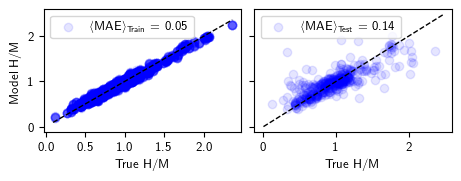

0.1274880762583891 0.00831162988595192


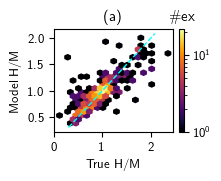

<class 'pandas.core.frame.DataFrame'>
Index(['0-norm', '2-norm', '3-norm', '5-norm', '7-norm', '10-norm',
       ' min Number', ' max Number', ' range Number', ' mean Number',
       ...
       'avg p valence electrons', 'avg d valence electrons',
       'avg f valence electrons', 'compound possible', 'max ionic char',
       'avg ionic char', 'E_HM min', 'E_HM max', 'E_HM mu', 'E_HM dev'],
      dtype='object', length=149)


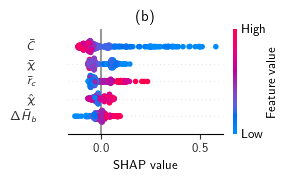

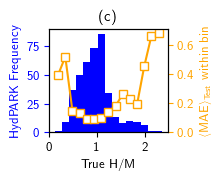

In [35]:
tosavename=os.path.join(figpath,'HtoM_plus_summary_%s.png'%modelVersion)
#tosavename=None
plot_summary(estplus_HtoM, aug_features_train, 
             savename=tosavename,
             prettify_Magpie=True, titles=[None,'(a)','(b)','(c)'])

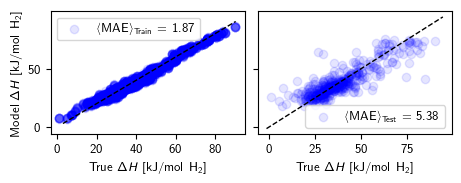

5.294970111105837 0.21386831624535022


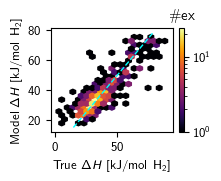

<class 'pandas.core.frame.DataFrame'>
Index(['0-norm', '2-norm', '3-norm', '5-norm', '7-norm', '10-norm',
       ' min Number', ' max Number', ' range Number', ' mean Number',
       ...
       'avg p valence electrons', 'avg d valence electrons',
       'avg f valence electrons', 'compound possible', 'max ionic char',
       'avg ionic char', 'E_HM min', 'E_HM max', 'E_HM mu', 'E_HM dev'],
      dtype='object', length=149)


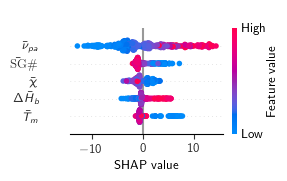

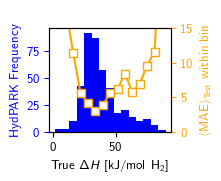

In [36]:
tosavename = os.path.join(figpath,'dH_plus_summary_%s.png'%modelVersion)
#tosavename = None
plot_summary(estplus_dH, aug_features_train,
             savename=tosavename,
             prettify_Magpie=True,limlower=-20,limupper=100,
             titles=[None,' ',' ',' '])

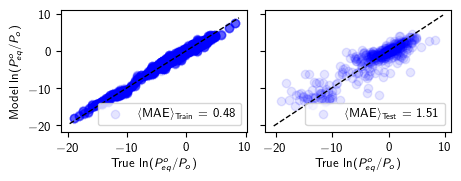

1.4910901617193475 0.0282987795245802


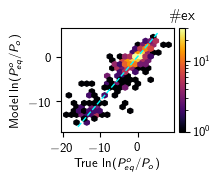

<class 'pandas.core.frame.DataFrame'>
Index(['0-norm', '2-norm', '3-norm', '5-norm', '7-norm', '10-norm',
       ' min Number', ' max Number', ' range Number', ' mean Number',
       ...
       'avg p valence electrons', 'avg d valence electrons',
       'avg f valence electrons', 'compound possible', 'max ionic char',
       'avg ionic char', 'E_HM min', 'E_HM max', 'E_HM mu', 'E_HM dev'],
      dtype='object', length=149)


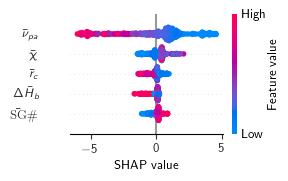

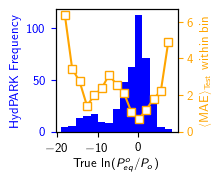

In [37]:
tosavename=os.path.join(figpath,'lnPeqo_plus_summary_%s.png'%modelVersion)
#tosavename=None
plot_summary(estplus_lnPeqo,aug_features_train,
             savename=tosavename,
             prettify_Magpie=True)

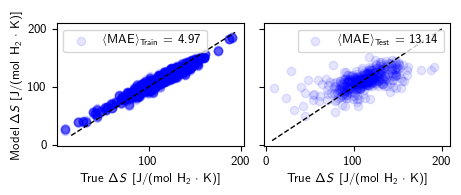

13.980669999064014 0.6974960531049852


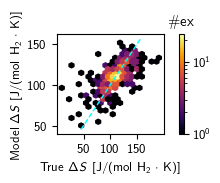

<class 'pandas.core.frame.DataFrame'>
Index(['0-norm', '2-norm', '3-norm', '5-norm', '7-norm', '10-norm',
       ' min Number', ' max Number', ' range Number', ' mean Number',
       ...
       'avg p valence electrons', 'avg d valence electrons',
       'avg f valence electrons', 'compound possible', 'max ionic char',
       'avg ionic char', 'E_HM min', 'E_HM max', 'E_HM mu', 'E_HM dev'],
      dtype='object', length=149)


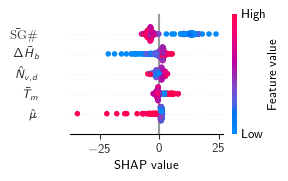

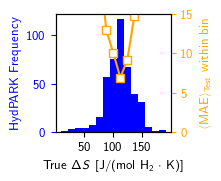

In [38]:
tosavename=os.path.join(figpath,'dS_plus_summary_%s.png'%modelVersion)
#tosavename=None
plot_summary(estplus_dS,aug_features_train,
             savename=tosavename,
             prettify_Magpie=True)

In [39]:
tosavename = 'figures/validation_summary_%s.png'%modelVersion
#tosavename=None
vertical_img_concat(['figures/HtoM_plus_summary_%s.png'%modelVersion,
                     'figures/dH_plus_summary_%s.png'%modelVersion,
                     'figures/dS_plus_summary_%s.png'%modelVersion,
                     'figures/lnPeqo_plus_summary_%s.png'%modelVersion],
                    savename=tosavename)

(4220, 4220, 4220, 4220) (1020, 1020, 1020, 1020)


## 4.3 Visualize performance vs. linear models

Primary feature:   mean GSvolume_pa
MAE in 'LnEquilibrium_Pressure_25C' linear model with '17' top features:  2.6061002142655902
R^2 in 'LnEquilibrium_Pressure_25C' linear model with '17' top features:  0.04555327660468178
Primary feature:   mean GSvolume_pa
MAE in 'Heat_of_Formation_kJperMolH2' linear model with '17' top features:  8.775233106106267
R^2 in 'Heat_of_Formation_kJperMolH2' linear model with '17' top features:  -0.5021318131185153
Primary feature:   mean SpaceGroupNumber
MAE in 'Entropy_of_Formation_JperMolH2perK' linear model with '22' top features:  16.147189122221143
R^2 in 'Entropy_of_Formation_JperMolH2perK' linear model with '22' top features:  -9.036462872079717
Primary feature:   mean Column
MAE in 'HtoM' linear model with '12' top features:  0.2191059763495565
R^2 in 'HtoM' linear model with '12' top features:  -0.7811274503062002
Primary feature:  Index([' mean MeltingT', 'E_HM mu', ' avg_dev Row', 'avg ionic char',
       ' mode NdValence', ' mean CovalentRadiu

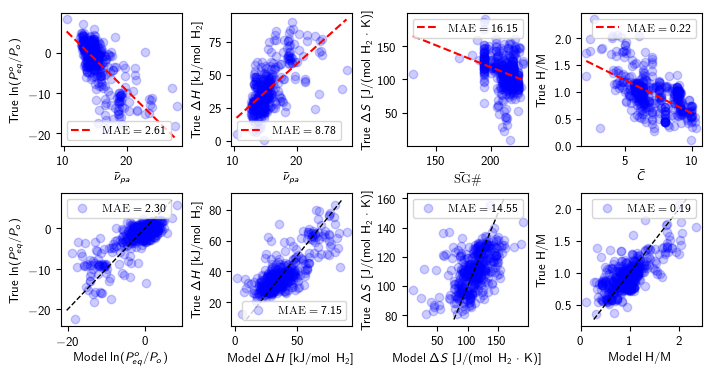

In [40]:
def lin_reg_primary_feature(model,ax):

    all_feature_importance = np.sum(model._all_feature_importance, axis=0)
    all_feature_importance/=(model._nsplits)
    sorted_idx = np.argsort(all_feature_importance)

    primary = model._allX.columns[sorted_idx[-1]]
    print("Primary feature: ", primary)
    X = np.array(model._X[:,sorted_idx[-1]]).reshape(-1,1)
    y = model._y
    fit, r2, pred, inds = sk_linear_model(X,y)
    MAE=np.mean(np.abs(pred-model._y))
    print("MAE in '%s' linear model with '%d' top features: "%(model._predict_column,len(primary)),MAE)
    print("R^2 in '%s' linear model with '%d' top features: "%(model._predict_column,len(primary)),r2)
    
    ax.scatter(X.squeeze(),y,c='blue',alpha=0.2)
    inds=X.squeeze().argsort()
    ax.plot(X.squeeze()[inds],pred[inds],c='r',linestyle='--',label=r'$\textrm{MAE}=%0.2f$'%MAE)
    return primary

def lin_reg_Nprimary_features(model,ax,N):

    all_feature_importance = np.sum(model._all_feature_importance, axis=0)
    all_feature_importance/=(model._nsplits)
    sorted_idx = np.argsort(all_feature_importance)

    primary = model._allX.columns[sorted_idx[-N:]]
    print("Primary feature: ", primary)
    X = np.array(model._X[:,sorted_idx[-N:]])
    y = model._y
    fit, r2, pred, inds = sk_linear_model(X,y)
    MAE=np.mean(np.abs(pred-model._y))
    print("MAE in '%s' linear model with '%d' top features: "%(model._predict_column,len(primary)),MAE)
    print("R^2 in '%s' linear model with '%d' top features: "%(model._predict_column,len(primary)),r2)
    
    ax.scatter(model._y,pred,c='blue',alpha=0.2,label=r'$\textrm{MAE}=%0.2f$'%MAE)
    draw_y_equals_x(ax)
    return primary
    
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(7,3.6),constrained_layout=True)

ax = axs[0,0]
primary = lin_reg_primary_feature(estplus_lnPeqo,ax)
ax.set_xlabel(prettify_magpie_v3(primary))
ax.set_ylabel(r"True %s"%column_to_label(estplus_lnPeqo._predict_column))
ax.legend(loc='best',prop={'size':8})

ax = axs[0,1]
primary = lin_reg_primary_feature(estplus_dH,ax)
ax.set_xlabel(prettify_magpie_v3(primary))
ax.set_ylabel(r"True %s"%column_to_label(estplus_dH._predict_column))
ax.legend(loc='best',prop={'size':8})

ax = axs[0,2]
primary = lin_reg_primary_feature(estplus_dS,ax)
ax.set_xlabel(prettify_magpie_v3(primary))
ax.set_ylabel(r"True %s"%column_to_label(estplus_dS._predict_column))
ax.legend(loc='best',prop={'size':8})

ax = axs[0,3]
primary = lin_reg_primary_feature(estplus_HtoM,ax)
ax.set_xlabel(prettify_magpie_v3(primary))
ax.set_ylabel(r"True %s"%column_to_label(estplus_HtoM._predict_column))
ax.legend(loc='best',prop={'size':8})

ax = axs[1,0]
primary = lin_reg_Nprimary_features(estplus_lnPeqo,ax,10)
ax.set_xlabel(r"Model %s"%column_to_label(estplus_lnPeqo._predict_column))
ax.set_ylabel(r"True %s"%column_to_label(estplus_lnPeqo._predict_column))
ax.legend(loc='best',prop={'size':8})

ax = axs[1,1]
primary = lin_reg_Nprimary_features(estplus_dH,ax,10)
ax.set_xlabel(r"Model %s"%column_to_label(estplus_dH._predict_column))
ax.set_ylabel(r"True %s"%column_to_label(estplus_dH._predict_column))
ax.legend(loc='best',prop={'size':8})

ax = axs[1,2]
primary = lin_reg_Nprimary_features(estplus_dS,ax,10)
ax.set_xlabel(r"Model %s"%column_to_label(estplus_dS._predict_column))
ax.set_ylabel(r"True %s"%column_to_label(estplus_dS._predict_column))
ax.legend(loc='best',prop={'size':8})

ax = axs[1,3]
primary = lin_reg_Nprimary_features(estplus_HtoM,ax,10)
ax.set_xlabel(r"Model %s"%column_to_label(estplus_HtoM._predict_column))
ax.set_ylabel(r"True %s"%column_to_label(estplus_HtoM._predict_column))
ax.legend(loc='best',prop={'size':8})

plt.savefig('figures/SI-linear_model_summary_%s.png'%modelVersion)

# 5. Results - screening exercises

In [41]:
modelVersion='v0.0.4'
estplus_dH, estplus_HtoM, estplus_lnPeqo, estplus_dS = load_all_models(modelVersion)

## 5.1 Prep the screening compositions and features

In [42]:
# Initialize the compositions for rHEA dataset
hypset = 'r3dHEA'
if hypset == 'rHEA':
    allels = ["Nb","Mo","Ti","Hf","Pd","Al","Zr","Cr","Ta","V"]
elif hypset == 'r3dHEA':
    Aelems = ["Mg", "Ti", "V", "Zr", "Nb", "Pd", "Hf", "Ta"]
    allels = ["Mg","Al", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Zr", "Nb", "Mo", "Pd", "Hf", "Ta"]
elif hypset == 'allHEA':
    Aelems = ["Li","Mg", "Ti", "V", "Zr", "Nb", "Pd", "Hf", "Ta"]
    allels = ["Li","Mg","Al", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Zr", "Nb", "Mo", "Pd", "Hf", "Ta"]

comb1 = combinations(allels,4)
comb2 = combinations(allels,5)
comb3 = combinations(allels,6)
allcombinations = list(comb1)+list(comb2)+list(comb3)
Aelems = ["Mg", "Ti", "V", "Zr", "Nb", "Pd", "Hf", "Ta"]
allcompositions = ["".join(c) for c in allcombinations if len(set(c) & set(Aelems))/len(c) > 0.25]
print(len(allcompositions))

# Get the MW of each compound
allpymcomps=[pym.core.Composition(c) for c in allcompositions]
allweights = np.array([c.weight/len(b) for c,b in zip(allpymcomps,allcombinations)])

17920


In [43]:
df_HEA = pd.DataFrame(allcompositions,columns=["Composition_Formula"])
aug_features_HEA =  featurize_by_version(modelVersion)(df_HEA)
#plshalp

Shape of df to featurize:  (17920, 1)


StrToComposition:   0%|          | 0/17920 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/17920 [00:00<?, ?it/s]

Shape of returned features:  (17920, 149)


In [44]:
features_HEA = magpie_featurize_data(df_HEA)

Shape of df to featurize:  (17920, 1)


StrToComposition:   0%|          | 0/17920 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/17920 [00:00<?, ?it/s]

Shape of returned features:  (17920, 145)


## 5.2. Screen all rHEA with ML models

In [45]:
lnPeqo_HEA_predict = estplus_lnPeqo._finalest.predict(aug_features_HEA)
dH_HEA_predict = estplus_dH._finalest.predict(aug_features_HEA)
dS_HEA_predict = estplus_dS._finalest.predict(aug_features_HEA)
HtoM_HEA_predict = estplus_HtoM._finalest.predict(aug_features_HEA)
lnPeqo_HEA_derived = -dH_HEA_predict*1000/(8.31441*(273.15+25))+dS_HEA_predict/8.31441

X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names


In [47]:
# # can potentially use the HEA SS phase selection rule to additionally down-select candidates
# phase_predict = pd.read_csv('ml_data/%s_phase_data_final.csv'%hypset)
# # just to make sure the ordering hasn't been scrambled in between
# np.testing.assert_array_equal(df_HEA['Composition_Formula'],phase_predict['Composition_Formula'])
# # indices where phase is predicted to be able to form a SS
# SS_mask = np.where((phase_predict['GBTPredict']==0) | (phase_predict['GBTPredict']==2))

# alternatively better to just recompute in this notebook
est_solidsolution = joblib.load('HEA_phase_estimator.joblib')
phase_predict = pd.DataFrame()
phase_predict['GBTPredict'] = est_solidsolution.predict(features_HEA)
SS_mask = np.where((phase_predict==0) | (phase_predict==2))

X has feature names, but GradientBoostingClassifier was fitted without feature names


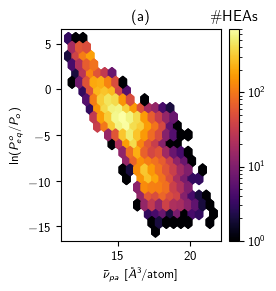

In [48]:
# v1 of plot, lnPeq vs. nu_pa, color coded by MW, with special compositions marked
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(2.65,2.8),constrained_layout=True)
                        #gridspec_kw={'width_ratios':[4,1]})

setcombinations = [set(c) for c in allcombinations]

s1=80
s2=30

predict_vars = ['LnEquilibrium_Pressure_25C']#,'HtoM']

cm = plt.cm.get_cmap('inferno')
for i in range(len(predict_vars)):
    if len(predict_vars) == 1:
        ax = axs
    else:
        ax = axs[i]
        
    if predict_vars[i] == 'HtoM':
        yname = predict_vars[i]
        yval = HtoM_HEA_predict
        strname=" mean CovalentRadius"
        xval = aug_features_HEA[strname]
        units = ' [pm]'
    elif predict_vars[i] == 'Heat_of_Formation_kJperMolH2' :
        yname = predict_vars[i]
        yval = dH_HEA_predict
        strname=' mean GSvolume_pa'
        xval = aug_features_HEA[strname]
        units = ' [$\AA^3$/atom]'
    elif predict_vars[i] == 'Entropy_of_Formation_JperMolH2perK' :
        yname = predict_vars[i]
        yval = dS_HEA_predict
        strname=' mean SpaceGroupNumber'
        xval = aug_features_HEA[strname]
        units = ' [J/(mol K)]'
    elif predict_vars[i] == 'LnEquilibrium_Pressure_25C' :
        yname = predict_vars[i]
        yval = lnPeqo_HEA_predict
        strname=" mean GSvolume_pa"
        xval = aug_features_HEA[strname]
        units = ' [$\AA^3$/atom]'
        
    ax.set_xlabel(prettify_magpie_v3(strname)+units)
    ax.set_ylabel(column_to_label(yname))

    sc = ax.hexbin(xval,yval,cmap=cm,mincnt=1,gridsize=20,bins='log')
                   #vmin=min(allweights), vmax=max(allweights),linewidths=1,alpha=0.5,c=allweights)      
        
    # Materials Gustav has already made
#     thiscomplist = ["Nb","Ti","Zr","Hf"]
#     plot_special_marker_fcn(ax,thiscomplist, setcombinations, xval,yval, edgecolor='black',marker='*',s=s1, c='maroon',linewidths=0.5)
    
#axs.legend(bbox_to_anchor=(1.35, 1.05), loc='upper left', prop={'size':7})

cb = plt.colorbar(sc)
cb.ax.set_title(r"\#HEAs")
#cb.ax.set_ylabel(r"\#HEAs")

sc = ax.hexbin(xval,yval,cmap=cm,mincnt=1,gridsize=20,bins='log')

ax.set_title('(a)')
tosavename=os.path.join(figpath,'%s_screening_%s.png'%(hypset,modelVersion))
plt.savefig(tosavename,dpi=600)
plt.show()

## 5.3. Pareto optimality of rHEAs (stationary)

Some possible technical targets: https://www.energy.gov/eere/fuelcells/doe-technical-targets-hydrogen-delivery

In [49]:
df_HEA['PymComp']=[pym.core.Composition(comp) for comp in df_HEA['Composition_Formula']]
df_HEA['dH']=dH_HEA_predict
df_HEA['dS']=dS_HEA_predict
df_HEA['HtoM']=HtoM_HEA_predict
df_HEA['lnPeqo']=lnPeqo_HEA_predict

In [50]:
# Additional objectives
Hwtpercent = np.array([100*wtfrac_from_HtoM(HtoM,comp)\
              for HtoM,comp in zip(HtoM_HEA_predict,df_HEA['PymComp'])])
matcost = np.array([compute_raw_material_cost(df_raw_mat,comp) for comp in df_HEA['PymComp']])

In [51]:
# costs to be minimized
paretoTarget=27
paretoThermo=dH_HEA_predict 
data = np.vstack((np.abs(np.array(dH_HEA_predict)-paretoTarget),-1*HtoM_HEA_predict,-1*Hwtpercent,matcost)).T
pareto = is_pareto_efficient(data)

In [52]:
oldmask = np.zeros(data.shape[0],dtype=bool)
allinds = np.arange(data.shape[0])
depth = np.zeros(data.shape[0],dtype=int)
ncalls = recursive_pareto(data,oldmask,allinds,depth,0)

177 pareto optimal materials this round
177 total materials
317 pareto optimal materials this round
494 total materials
511 pareto optimal materials this round
1005 total materials
627 pareto optimal materials this round
1632 total materials
803 pareto optimal materials this round
2435 total materials
924 pareto optimal materials this round
3359 total materials
1059 pareto optimal materials this round
4418 total materials
1173 pareto optimal materials this round
5591 total materials
1216 pareto optimal materials this round
6807 total materials
1283 pareto optimal materials this round
8090 total materials
1302 pareto optimal materials this round
9392 total materials
1157 pareto optimal materials this round
10549 total materials
1224 pareto optimal materials this round
11773 total materials
1194 pareto optimal materials this round
12967 total materials
979 pareto optimal materials this round
13946 total materials
911 pareto optimal materials this round
14857 total materials
764 pareto op

In [53]:
df_pareto = pd.DataFrame(data[pareto],
                         columns=['abs(dH-27)','HtoM','Hwtpercent','cost'])
df_pareto['Composition_Formula']=df_HEA['Composition_Formula'][pareto].tolist()
df_pareto['HtoM'] = -1*np.array(df_pareto['HtoM'])
df_pareto['Hwtpercent'] = -1*np.array(df_pareto['Hwtpercent'])
df_pareto['dH']=dH_HEA_predict[pareto].tolist()
df_pareto['IM0_SS1_SS+IM2']=phase_predict['GBTPredict'][pareto].tolist()
df_pareto['Sorted'] = ["".join([str(e) for e in sorted([el for el in pym.core.Composition(c).elements if str(el) !='H'], key=lambda x: x.number)]) 
               for c in df_pareto['Composition_Formula']]
df_pareto = df_pareto[['Composition_Formula','Sorted','IM0_SS1_SS+IM2','dH','abs(dH-27)','HtoM','Hwtpercent','cost']]
#df_pareto.to_csv('ml_data/%s_pareto_front_initial.csv'%hypset)

In [54]:
df_pareto_levels = pd.DataFrame(data,
                                columns=['abs(dH-27)','HtoM','Hwtpercent','cost'])
df_pareto_levels['Composition_Formula']=df_HEA['Composition_Formula'].tolist()
df_pareto_levels['HtoM'] = -1*np.array(df_pareto_levels['HtoM'])
df_pareto_levels['Hwtpercent'] = -1*np.array(df_pareto_levels['Hwtpercent'])
df_pareto_levels['dH']=dH_HEA_predict.tolist()
df_pareto_levels['IM0_SS1_SS+IM2']=phase_predict['GBTPredict'].tolist()
df_pareto_levels['Sorted'] = ["".join([str(e) for e in sorted([el for el in pym.core.Composition(c).elements if str(el) !='H'], key=lambda x: x.number)]) 
               for c in df_pareto_levels['Composition_Formula']]
df_pareto_levels['pareto_level'] = depth
df_pareto_levels = df_pareto_levels[['Composition_Formula','Sorted','IM0_SS1_SS+IM2','dH','abs(dH-27)','HtoM','Hwtpercent','cost','pareto_level']]
#df_pareto_levels.to_csv('ml_data/%s_pareto_levels.csv'%hypset)

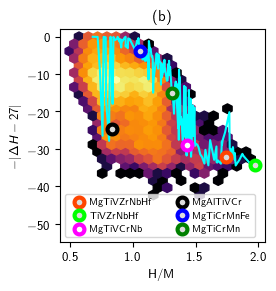

In [55]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(2.65,2.8),constrained_layout=True)

#cm = plt.cm.get_cmap('viridis')
cm = plt.cm.get_cmap('inferno')
inds = np.arange(len(Hwtpercent))
np.random.shuffle(inds)
# sc = ax.scatter(np.take(HtoM_rHEA_predict,inds),np.take(-np.abs(np.array(dH_rHEA_predict)-27),inds),
#            c=np.take(Hwtpercent,inds),vmin=min(Hwtpercent), vmax=max(Hwtpercent),
#            cmap=cm,linewidths=1,alpha=1)

sc = ax.hexbin(np.take(HtoM_HEA_predict,inds),np.take(-np.abs(np.array(dH_HEA_predict)-paretoTarget),inds),
               cmap=cm,mincnt=1,gridsize=20,bins='log')

# All data
ax.set_xlabel(r'$\mathrm{H/M}$')
ax.set_ylabel(r'$-|\Delta H-%.f|$'%paretoTarget)

# Pareto frontier
pareto_x = df_pareto['HtoM']
sortedinds = np.argsort(pareto_x)
pareto_y = df_pareto['abs(dH-27)']
ax.plot(pareto_x[sortedinds],-1*pareto_y[sortedinds],c='cyan',linestyle='-')#,label='4D Pareto')




# Some materials to potentially highlight that we haven't tested
# MgTiMnFeZrMo, MgTiFeCo, MgTiMnFe 	

msize = 50
ethick = 3
intc='gainsboro'

df_MgTiVZrNbHf = df_pareto_levels[(df_pareto_levels['Composition_Formula']=='MgTiVZrNbHf')]
ax.scatter(df_MgTiVZrNbHf['HtoM'],-np.abs(df_MgTiVZrNbHf['dH']-27),linewidth=ethick,
           marker='o',c=intc,edgecolor='orangered',s=msize,zorder=10000,label='MgTiVZrNbHf')

df_TiVZrNbHf = df_pareto_levels[(df_pareto_levels['Composition_Formula']=='TiVZrNbHf')]
ax.scatter(df_TiVZrNbHf['HtoM'],-np.abs(df_TiVZrNbHf['dH']-27),linewidth=ethick,
           marker='o',c=intc,edgecolor='lime',s=msize,zorder=10000,label='TiVZrNbHf')

df_MgTiVCrNb = df_pareto_levels[(df_pareto_levels['Composition_Formula']=='MgTiVCrNb')]
ax.scatter(df_MgTiVCrNb['HtoM'],-np.abs(df_MgTiVCrNb['dH']-27),linewidth=ethick,
           marker='o',c='white',edgecolor='magenta',s=msize,zorder=10000,label='MgTiVCrNb')

df_MgAlTiVCr = df_pareto_levels[(df_pareto_levels['Composition_Formula']=='MgAlTiVCr')]
ax.scatter(df_MgAlTiVCr['HtoM'],-np.abs(df_MgAlTiVCr['dH']-27),linewidth=ethick,
           marker='o',c=intc,edgecolor='black',s=msize,zorder=10000,label='MgAlTiVCr')

df_MgTiMnFe = df_pareto_levels[df_pareto_levels['Composition_Formula']=='MgTiCrMnFe']
ax.scatter(df_MgTiMnFe['HtoM'],-np.abs(df_MgTiMnFe['dH']-27),linewidth=ethick,
           marker='o',c='gainsboro',edgecolor='blue',s=msize,zorder=10000,label='MgTiCrMnFe')

df_MgTiCrMn = df_pareto_levels[df_pareto_levels['Composition_Formula']=='MgTiCrMn']
ax.scatter(df_MgTiCrMn['HtoM'],-np.abs(df_MgTiCrMn['dH']-27),linewidth=ethick,
           marker='o',c='gainsboro',edgecolor='green',s=msize,zorder=10000,label='MgTiCrMn')

ax.legend(loc='lower left',prop={'size':7},ncol=2,handletextpad=0.1)#,bbox_to_anchor=(-1,-0.5))
ax.set_title('(b)')
ylim=ax.get_ylim()
ax.set_ylim((-55,ylim[1]))
#plt.tight_layout(pad=1)

ylim = ax.get_ylim()
#xlim = ax.set_xlim((0.5,2))
#cb = plt.colorbar(sc)
#cb.ax.set_title(r"$Hwt\%$")
#cb.ax.set_title(r"\#HEAs")
#cb.ax.set_ylabel(r"\#HEAs")

tosavename = 'figures/%s_dH_vs_HtoM_pareto_%s.png'%(hypset,modelVersion)
plt.savefig(tosavename,dpi=600)

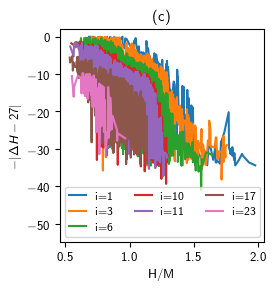

In [56]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(2.65,2.8),constrained_layout=True)

for i in [1,3,6,10]+list(range(11,max(df_pareto_levels['pareto_level'])+1,6)):
    
    xvals = np.array(df_pareto_levels['HtoM'][df_pareto_levels['pareto_level']==i])
    yvals = np.array(df_pareto_levels['abs(dH-27)'][df_pareto_levels['pareto_level']==i])
    sortedinds = np.argsort(xvals)

    ax.plot(xvals[sortedinds],-1*yvals[sortedinds],label='i=%d'%i)
ax.legend(prop={'size':8,},loc='lower center',ncol=3,handlelength=1.5)#,bbox_to_anchor=(1.02,1.0))
ax.set_title('(c)')
ax.set_xlabel(r'$\mathrm{H/M}$')
ax.set_ylabel(r'$-|\Delta H-%.f|$'%paretoTarget)
ax.set_ylim(ylim)

tosavename = 'figures/%s_pareto_evolution_%s.png'%(hypset,modelVersion)
plt.savefig(tosavename,dpi=600)

## 5.4 Combine screening/Pareto optimality figures

In [57]:
import sys
from PIL import Image

images = [Image.open(x) for x in ['figures/%s_screening_%s.png'%(hypset,modelVersion), 
                                  'figures/%s_dH_vs_HtoM_pareto_%s.png'%(hypset,modelVersion), 
                                  'figures/%s_pareto_evolution_%s.png'%(hypset,modelVersion)]]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

new_im.save('figures/%s_pareto_screening_all_%s.png'%(hypset,modelVersion))

In [58]:
df_pareto_levels[(df_pareto_levels['Composition_Formula']=='MgTiVZrNbHf') |\
                 (df_pareto_levels['Composition_Formula']=='TiVZrNbHf') |\
                 (df_pareto_levels['Composition_Formula']=='MgAlTiVCr') |\
                 (df_pareto_levels['Composition_Formula']=='AlTiVCr') |\
                 (df_pareto_levels['Composition_Formula']=='MgTiVCrNb') |\
                 (df_pareto_levels['Composition_Formula']=='TiVCrNb')]

,Composition_Formula,Sorted,IM0_SS1_SS+IM2,dH,abs(dH-27),HtoM,Hwtpercent,cost,pareto_level
476,AlTiVCr,AlTiVCr,1.0,41.128847,14.128847,0.576885,1.291343,98.397500,15
686,TiVCrNb,TiVCrNb,1.0,47.195566,20.195566,1.768316,2.842216,116.325000,1
1582,MgAlTiVCr,MgAlTiVCr,1.0,51.768588,24.768588,0.835543,2.041128,79.182000,5
1988,MgTiVCrNb,MgTiVCrNb,2.0,56.082835,29.082835,1.430299,2.619056,93.524000,2
4447,TiVZrNbHf,TiVZrNbHf,1.0,61.427264,34.427264,1.974626,2.111144,278.460000,1
8199,MgTiVZrNbHf,MgTiVZrNbHf,1.0,59.232622,32.232622,1.742510,2.123447,232.436667,2


In [61]:
# Filter candidates based on any desired calculations/criteria
df_pareto_levels[(df_pareto_levels['pareto_level']==1)&\
                 (df_pareto_levels['IM0_SS1_SS+IM2']==1)
                ].sort_values('dH')

,Composition_Formula,Sorted,IM0_SS1_SS+IM2,dH,abs(dH-27),HtoM,Hwtpercent,cost,pareto_level
2345,MgVCrMnFe,MgVCrMnFe,1.0,27.010175,0.010175,0.943202,1.957935,76.992000,1
8934,MgVCrMnFeCu,MgVCrMnFeCu,1.0,27.148143,0.148143,0.785114,1.550042,65.160000,1
6050,MnFeNiZrNb,MnFeNiZrNb,1.0,28.320160,1.320160,1.033737,1.451918,25.208000,1
2346,MgVCrMnCo,MgVCrMnCo,1.0,29.638618,2.638618,0.944157,1.935261,83.468000,1
8217,MgTiCrMnFeCo,MgTiCrMnFeCo,1.0,29.868537,2.868537,0.908684,1.835594,9.693333,1
...,...,...,...,...,...,...,...,...,...
2044,MgTiVZrNb,MgTiVZrNb,1.0,60.477039,33.477039,1.666267,2.660452,98.924000,1
745,TiVZrHf,TiVZrHf,1.0,60.675359,33.675359,1.926899,2.064569,329.700000,1
157,MgTiZrTa,MgTiZrTa,1.0,60.694429,33.694429,1.671350,1.919345,88.780000,1
4447,TiVZrNbHf,TiVZrNbHf,1.0,61.427264,34.427264,1.974626,2.111144,278.460000,1
